In [1]:
import sklearn
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import adjusted_mutual_info_score as ami, silhouette_score as sil_score, \
    silhouette_samples as sil_samples
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans as kmeans
from utils import get_prune, post_pruning, classification_accuracy, plot_tsne, plot_corr, print_report, learning_curves
from preprocessing import preprocess_bank_data, preprocess_heart_data
from models import create_model

Using TensorFlow backend.


In [2]:
# read csv    
heart = pd.read_csv('./data/heart.csv')
bank = pd.read_csv('./data/bank.csv', sep=';')
# main areas

heart_final, heart_scalers = preprocess_heart_data(heart)
bank_final, bank_scalers = preprocess_bank_data(bank)


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return sel

In [112]:
target_column = 'target'

X = heart_final.loc[:, heart_final.columns != target_column]
Y = heart_final.loc[:, heart_final.columns == target_column]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [11]:
from sklearn.decomposition import FastICA, PCA, TruncatedSVD
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection

model = KerasClassifier(build_fn=create_model, verbose=0)
batch_size = [8, 16]
epochs = [15, 25, 35, 40]
components = [10,15,25]
estimators = [('reduce_dim', GaussianRandomProjection()), ('clf', model)]
param_grid = [dict(reduce_dim__n_components=[10], clf__input_dim=[10], clf__batch_size=batch_size, clf__epochs=epochs),
             dict(reduce_dim__n_components=[15], clf__input_dim=[15], clf__batch_size=batch_size, clf__epochs=epochs),
             dict(reduce_dim__n_components=[25], clf__input_dim=[25], clf__batch_size=batch_size, clf__epochs=epochs)]
pipe = Pipeline(estimators)
grid_search = GridSearchCV(pipe, param_grid=param_grid)

In [12]:
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim', GaussianRandomProjection(eps=0.1, n_components='auto', random_state=None)), ('clf', <keras.wrappers.scikit_learn.KerasClassifier object at 0x14f8133c8>)]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'reduce_dim__n_components': [10], 'clf__input_dim': [10], 'clf__batch_size': [8, 16], 'clf__epochs': [15, 25, 35, 40]}, {'reduce_dim__n_components': [15], 'clf__input_dim': [15], 'clf__batch_size': [8, 16], 'clf__epochs': [15, 25, 35, 40]}, {'reduce_dim__n_components': [25], 'clf__input_dim': [25], 'clf__batch_size': [8, 16], 'clf__epochs': [15, 25, 35, 40]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [13]:
from sklearn.metrics import classification_report

print('{classifer} \n {report}'.format(
            classifer='Keras Model', 
            report=classification_report(np.round(grid_search.predict(X_test)), y_test)
        ))

Keras Model 
               precision    recall  f1-score   support

           0       0.83      0.78      0.81        37
           1       0.80      0.85      0.83        39

   micro avg       0.82      0.82      0.82        76
   macro avg       0.82      0.81      0.82        76
weighted avg       0.82      0.82      0.82        76



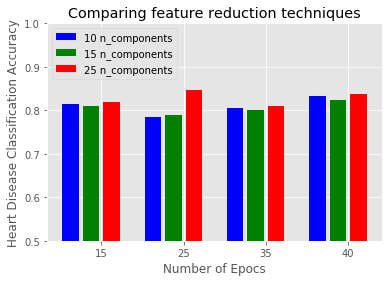

In [16]:
# from sklearn_evaluation import plot
components = [10,15,25]
# plot.grid_search(grid_search.cv_results_, change='param_clf__batch_size', kind='bar')
mean_scores = np.array(grid_search.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(batch_size), -1, len(epochs))


# select score for best epochs
mean_scores = mean_scores.max(axis=0)
print(mean_scores)
bar_offsets = (np.arange(len(epochs)) *
               (len(components) + 1) + .5)

import matplotlib.pyplot as plt

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(components, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=str(label) + ' n_components', color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Number of Epocs')
plt.xticks(bar_offsets + len(components) / 2, epochs)
plt.ylabel('Heart Disease Classification Accuracy')
plt.ylim((0.5, 1))
plt.legend(loc='upper left')

plt.savefig('GaussianRandomProjection_reduction_Keras')

grid_search.best_params_

In [18]:
from sklearn.metrics.pairwise import pairwise_distances
import scipy.sparse as sps
from scipy.linalg import pinv
from scipy.stats import kurtosis

def kurtotic(X1):
    return np.abs(np.array(kurtosis(X1))).mean()

def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

    
def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)

def cluster_sample_silhouette_score(X, clusterLabels):
    return silhouette_samples(X, clusterLabels)

def cluster_silhouette_score(X, clusterLabels):
    return silhouette_score(X, clusterLabels)

def cluster_acc(Y,clusterLabels):
    Y = Y.squeeze(1)
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
    return accuracy_score(Y,pred)

In [ ]:
from sklearn.decomposition import FastICA, PCA, TruncatedSVD
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection

reconstruction_error = []
pair_wise_construction = []
kurtooose = []
components = [2,5,10,15,25,30,35,40,45]

for x_ in components:
    pca = GaussianRandomProjection(n_components=x_)
    x = pca.fit(X)

    X_r = pca.transform(X)

    print(reconstructionError(x, X), x_)
    reconstruction_error.append(reconstructionError(x, X))
    pair_wise_construction.append(pairwiseDistCorr(X_r, X))
#     kurtooose.append(kurtotic(X_r))
    
    if x_ == 45:
        plt.figure()
        plt.plot(components, reconstruction_error, label='reconstruction error')
        plt.plot(components, pair_wise_construction, label='pairwise correlation')
        plt.xlabel('Number of Components')
        plt.ylabel('ReconstructionError and PairwiseCorrelation (%)') #for each component
        plt.title('Portuguese Bank Dataset Reconstruction Error')
        plt.legend()
        plt.savefig('GaussianRandomProjection_explained_variance_Bank')

    

    plt.figure()
    labels = ['green' if y else 'red' for y in Y.values]

    plt.scatter(X_r[:,0], X_r[:,np.random.randint(1, x_)], color=labels)
    plt.savefig('Bank_GaussianRandomProjection_reduction_nComponents_' + str(x_))

In [ ]:
scores =  np.array(grid_search.cv_results_['mean_test_score'])
scores.reshape(len(batch_size), -1, 4)

In [ ]:
mean_scores_ = mean_scores.max(axis=0)
bar_offsets_ = (np.arange(len([1])) *
               (len(batch_size) + 1) + .5)
print(list(zip(batch_size, mean_scores_)))
print(bar_offsets_)
for i, (label, reducer_scores) in enumerate(zip(batch_size, mean_scores_)):
    print(label, reducer_scores)
    plt.scatter(bar_offsets_ + i, reducer_scores, label=label, color=COLORS[i])

/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


2


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


3


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


5


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


7


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


15


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


25


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


30


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


35


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


40


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


45


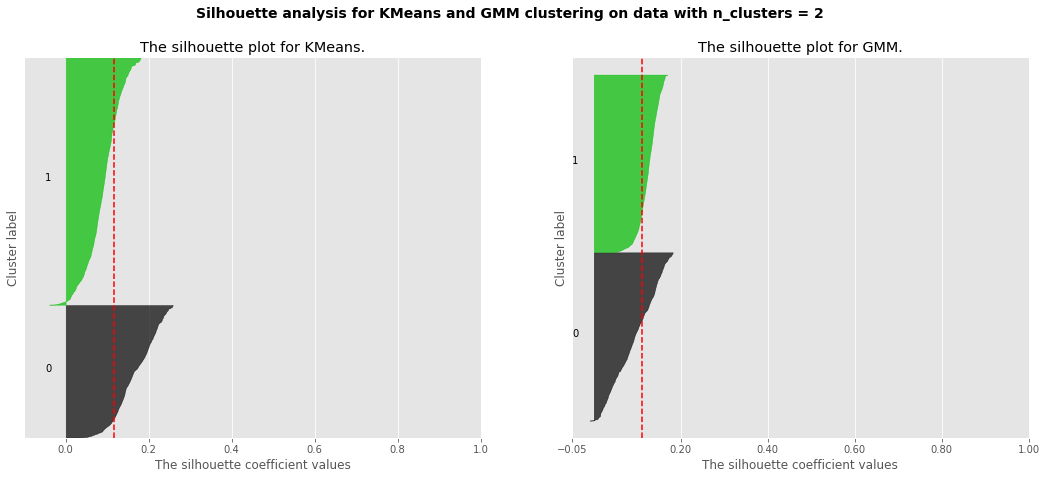

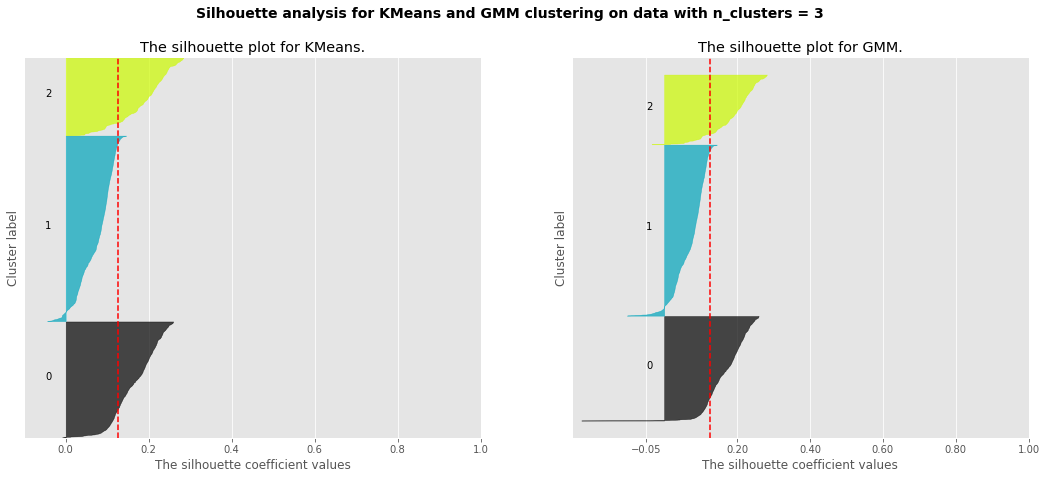

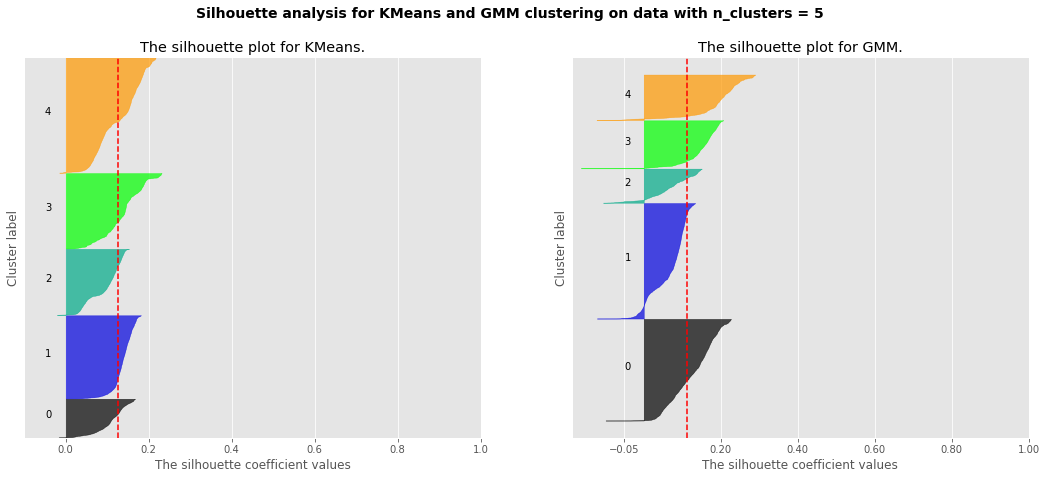

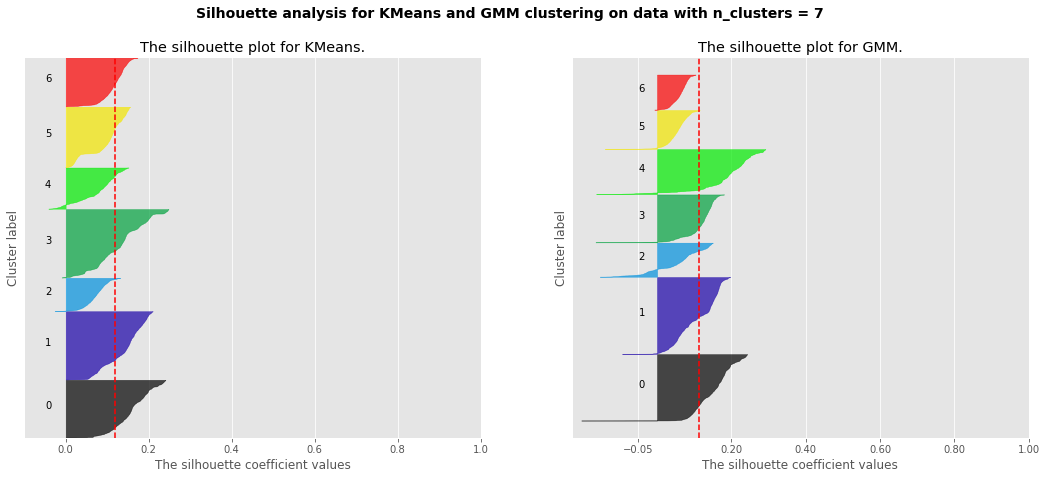

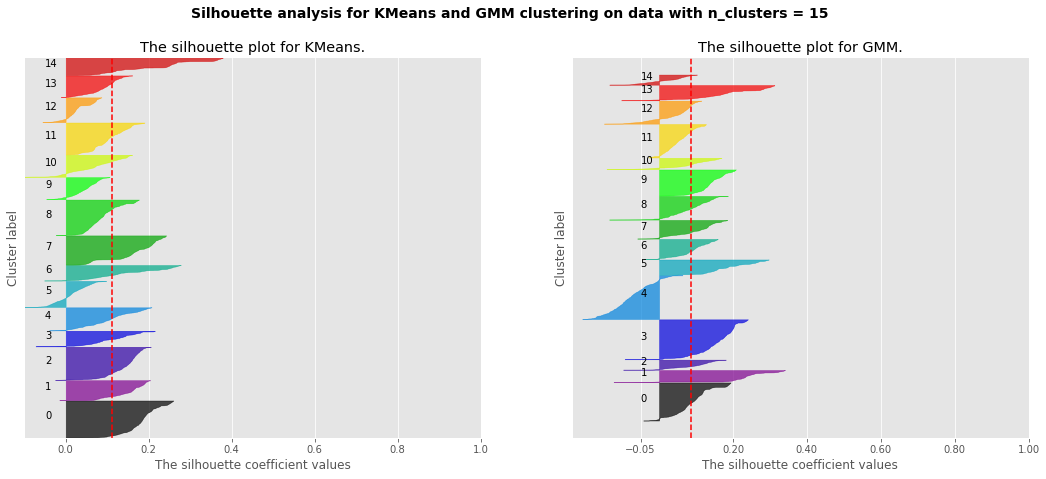

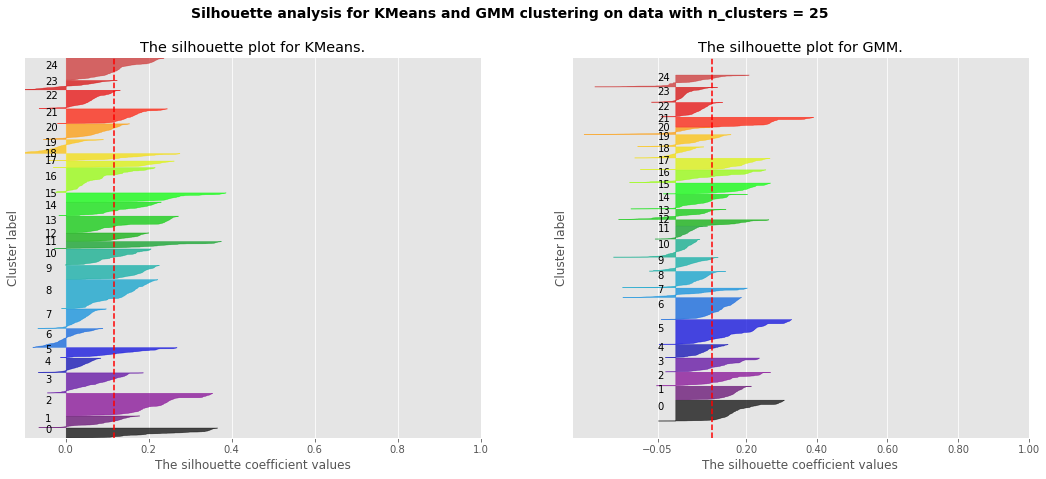

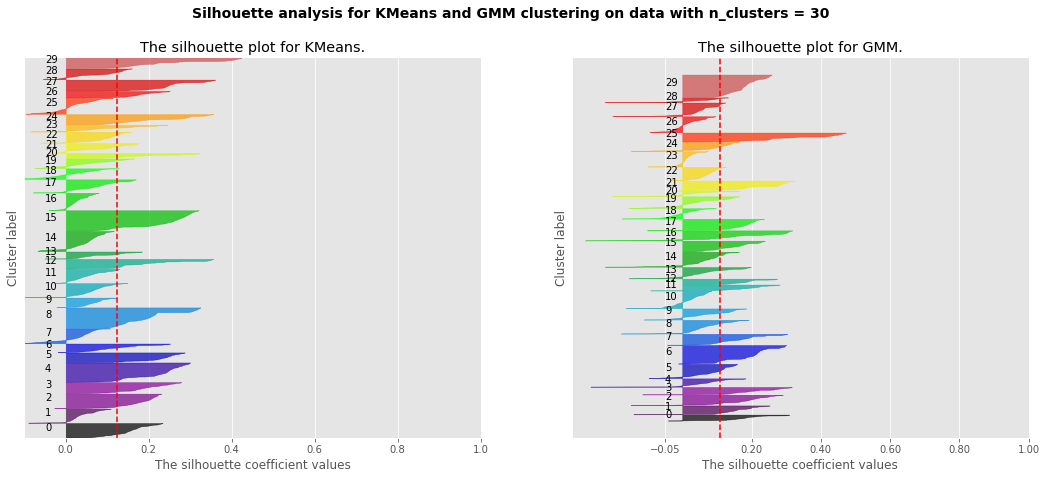

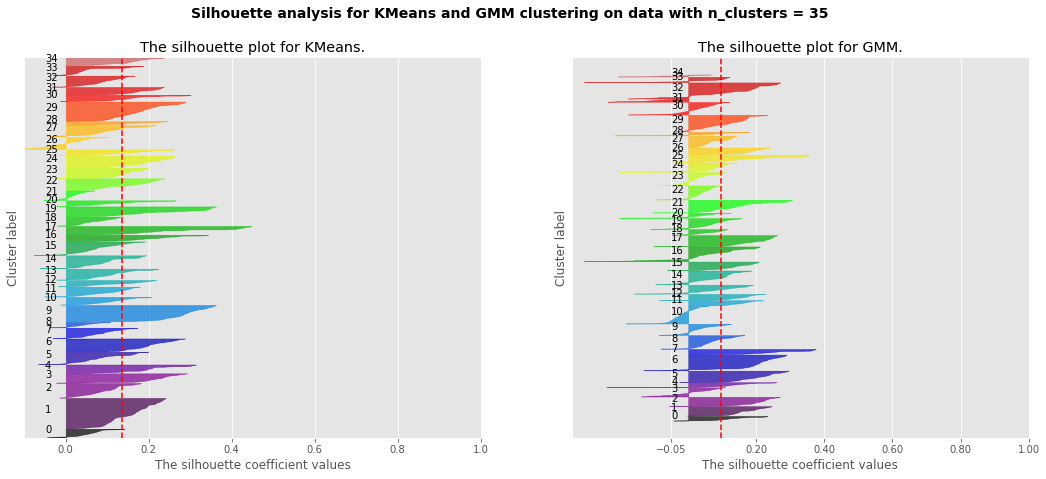

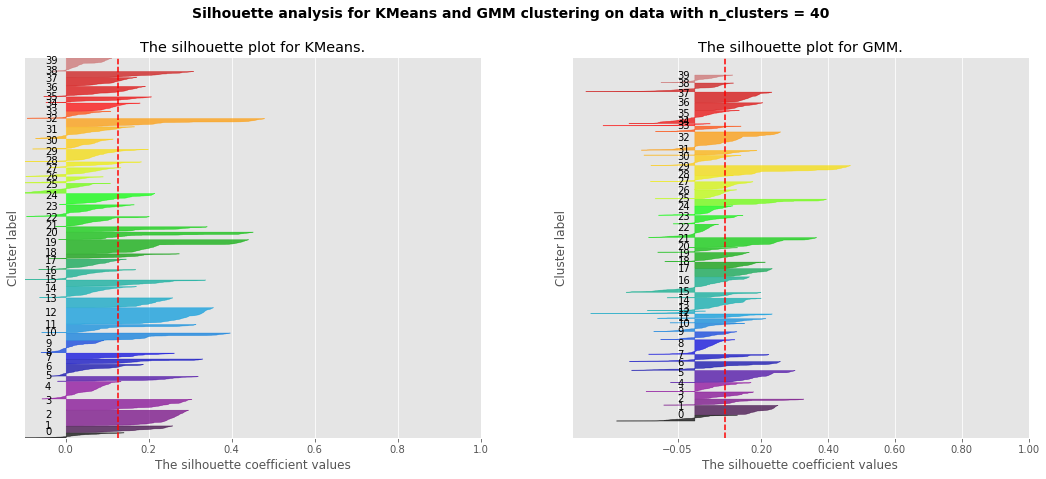

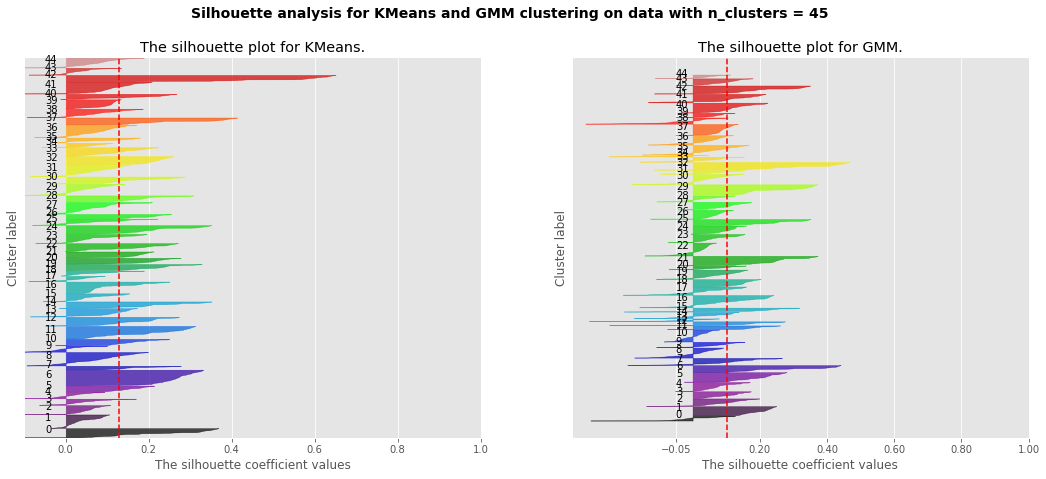

In [70]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans as kmeans
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import silhouette_samples, silhouette_score
from collections import defaultdict, Counter
from sklearn.metrics import accuracy_score
import matplotlib.cm as cm


clusters = [2,3,5,7,15,25, 30, 35, 40, 45]
#%% Data for 1-3
SSE = defaultdict(dict)
ll = defaultdict(lambda: defaultdict(dict))
acc = defaultdict(lambda: defaultdict(dict))
adjMI = defaultdict(lambda: defaultdict(dict))
SS = defaultdict(lambda: defaultdict(dict))
SSS = defaultdict(lambda: defaultdict(dict))
km = kmeans(random_state=5)
gmm = GMM(random_state=5)


for k in clusters:
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    km.fit(X)
    gmm.fit(X)
    SSE[k]['Heart'] = km.score(X)
    ll[k]['Heart']['AIC'] = gmm.aic(X)
    ll[k]['Heart']['BIC'] = gmm.bic(X) 
    SS[k]['Heart']['Kmeans'] = cluster_silhouette_score(X, km.predict(X))
    SS[k]['Heart']['GMM'] = cluster_silhouette_score(X, gmm.predict(X))
    SSS[k]['Heart']['Kmeans'] = cluster_sample_silhouette_score(X, km.predict(X))
    SSS[k]['Heart']['GMM'] = cluster_sample_silhouette_score(X, gmm.predict(X))
    acc[k]['Heart']['Kmeans'] = cluster_acc(Y,km.predict(X))
    acc[k]['Heart']['GMM'] = cluster_acc(Y,gmm.predict(X))
    adjMI[k]['Heart']['Kmeans'] = ami(Y.squeeze(1),km.predict(X))
    adjMI[k]['Heart']['GMM'] = ami(Y.squeeze(1),gmm.predict(X))
    print(k)
    
    
    sample_silhouette_values = SSS[k]['Heart']['Kmeans']
    cluster_labels = km.predict(X)
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    ax1.set_title("The silhouette plot for KMeans.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=SS[k]['Heart']['Kmeans'], color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
    sample_silhouette_values = SSS[k]['Heart']['GMM']
    cluster_labels = gmm.predict(X)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax2.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax2.set_title("The silhouette plot for GMM.")
    ax2.set_xlabel("The silhouette coefficient values")
    ax2.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax2.axvline(x=SS[k]['Heart']['GMM'], color="red", linestyle="--")

    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.05, 0.2, 0.4, 0.6, 0.8, 1])
#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
#     X_ = km.transform(X)
#     X_ = (X_ - X_.min()) / (X_.max() - X_.min())
#     ax2.scatter(X_[:,0], X_[:,1], marker='.', s=30, lw=0, alpha=0.7,
#                 c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = km.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans and GMM clustering on data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')
    plt.savefig('BANK_Silhouetter_' + str(k))
plt.show()

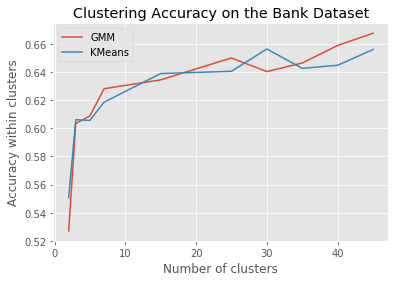

In [71]:
gmm = [value['Heart']['GMM'] for key, value in acc.items()]
kmm = [value['Heart']['Kmeans'] for key, value in acc.items()]



plt.figure()

plt.plot(clusters, gmm, label='GMM')
plt.plot(clusters, kmm, label='KMeans')
plt.ylabel('Accuracy within clusters')
plt.xlabel('Number of clusters')
plt.title('Clustering Accuracy on the Bank Dataset')
plt.legend()
plt.savefig('Cluster_analysis_accuracy_bank')

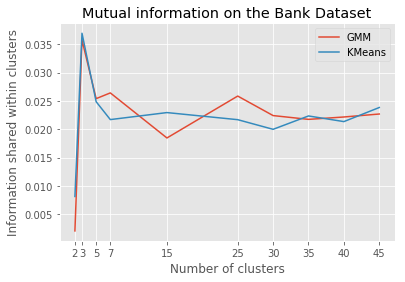

In [74]:
gmm_AMI = [value['Heart']['GMM'] for key, value in adjMI.items()]
kmm_AMI = [value['Heart']['Kmeans'] for key, value in adjMI.items()]

plt.figure()

plt.plot(clusters, gmm_AMI, label='GMM')
plt.plot(clusters, kmm_AMI, label='KMeans')
plt.ylabel('Information shared within clusters')
plt.xlabel('Number of clusters')
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
plt.title('Mutual information on the Bank Dataset')
plt.legend()
plt.savefig('Cluster_analysis_information_bank')

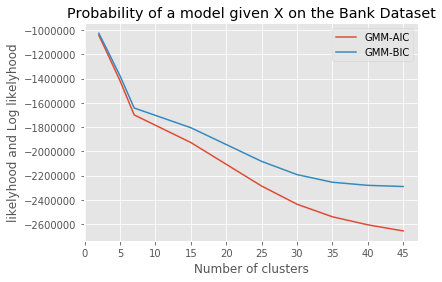

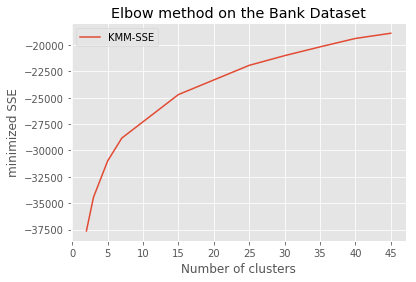

In [75]:
gmm_LL_AIC = [value['Heart']['AIC'] for key, value in ll.items()]
gmm_LL_BIC = [value['Heart']['BIC'] for key, value in ll.items()]
kmm_SSE = [value['Heart'] for key, value in SSE.items()]

plt.figure()
plt.plot(clusters, gmm_LL_AIC, label='GMM-AIC')
plt.plot(clusters, gmm_LL_BIC, label='GMM-BIC')
plt.ylabel('likelyhood and Log likelyhood')
plt.xlabel('Number of clusters')
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
plt.title('Probability of a model given X on the Bank Dataset')
plt.legend()
plt.savefig('Cluster_analysis_prob_bank')

plt.figure()
plt.plot(clusters, kmm_SSE, label='KMM-SSE')
plt.ylabel('minimized SSE')
plt.xlabel('Number of clusters')
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
plt.title('Elbow method on the Bank Dataset')
plt.legend()
plt.savefig('Cluster_analysis_elbow_bank')

In [239]:
from sklearn.decomposition import PCA
from sklearn.metrics.scorer import make_scorer

my_scorer = make_scorer(cluster_acc, greater_is_better=True)
km = kmeans(random_state=5)
gmm = GMM(random_state=5)

components = [2, 5, 10, 15, 25]
estimators = [('reduce_dim', FastICA(max_iter=1000, tol=1)), ('clf', km)]
param_grid = [dict(reduce_dim__n_components=components, clf__n_clusters=components)]
pipe = Pipeline(estimators)
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring=my_scorer)
# pipe.set_params(clf__input_dim=10) 

In [240]:
grid_search.fit(X, Y)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=1000,
    n_components=None, random_state=None, tol=1, w_init=None, whiten=True)), ('clf', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=5, tol=0.0001, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'reduce_dim__n_components': [2, 5, 10, 15, 25], 'clf__n_clusters': [2, 5, 10, 15, 25]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(cluster_acc), verbose=0)

In [241]:
from sklearn.metrics import classification_report

print('{classifer} \n {report}'.format(
            classifer='K-Means Model', 
            report=cluster_acc(y_train, grid_search.predict(X_train))
        ))

K-Means Model 
 0.8325991189427313


2 [[0.89438944 0.91089109 0.92739274 0.87788779 0.89108911]] [ 0.5  6.5 12.5 18.5 24.5]
5 [[0.94389439 0.90429043 0.92079208 0.9009901  0.89768977]] [ 0.5  6.5 12.5 18.5 24.5]
10 [[0.94719472 0.94389439 0.91749175 0.93069307 0.90759076]] [ 0.5  6.5 12.5 18.5 24.5]
15 [[0.94719472 0.95049505 0.94059406 0.9339934  0.92079208]] [ 0.5  6.5 12.5 18.5 24.5]
25 [[0.95379538 0.94719472 0.94719472 0.95379538 0.9339934 ]] [ 0.5  6.5 12.5 18.5 24.5]


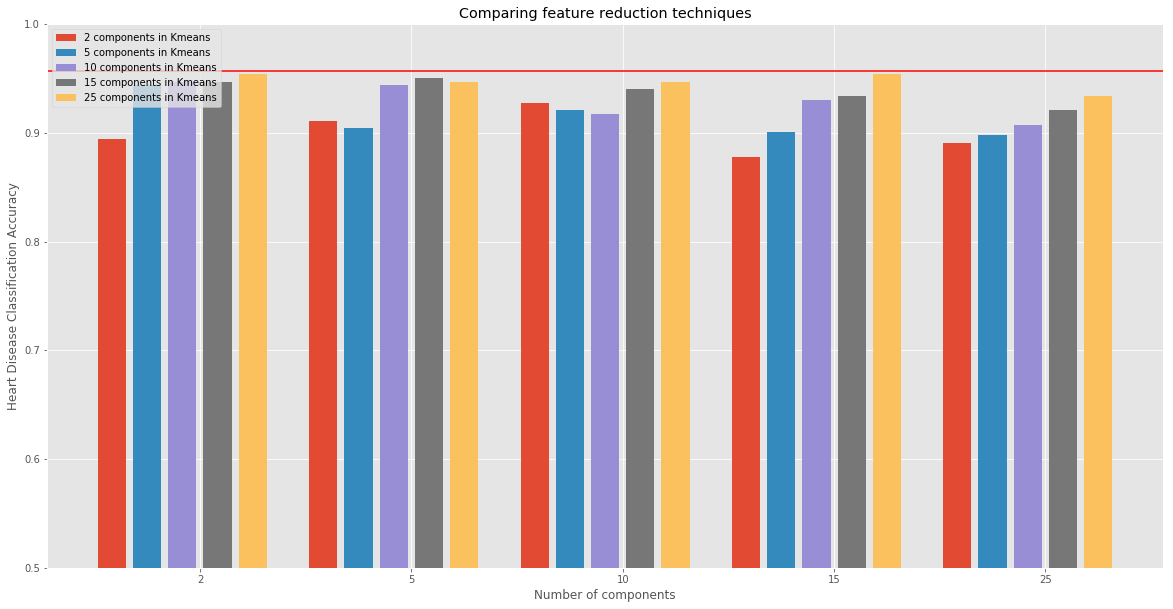

In [242]:
mean_scores = np.array(grid_search.cv_results_['mean_test_score']).reshape(len(components), -1, len(components))
bar_offsets_ = (np.arange(len(components)) *
               (len(components) + 1) + .5)

import matplotlib.pyplot as plt
import matplotlib.colors

plt.figure(figsize=(20,10))
COLORS = np.arange(len(components))
for i, (label, reducer_scores) in enumerate(zip(components, mean_scores)):
    print(label, reducer_scores, bar_offsets_)
    plt.bar(bar_offsets_ + i, reducer_scores.flatten(), label=str(label) + ' components in Kmeans')
plt.axhline(y=0.957, color='r', linestyle='-')
plt.title("Comparing feature reduction techniques")
plt.xlabel('Number of components')
plt.xticks(bar_offsets_ + len(components) / 2, components)
plt.ylabel('Heart Disease Classification Accuracy')
plt.ylim((0.5, 1))
plt.legend(loc='upper left')

plt.show()

In [243]:
mean_scores_ = mean_scores.max(axis=0)

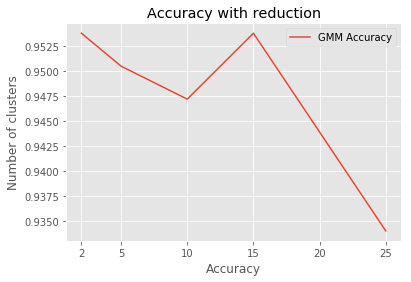

In [244]:
plt.figure()

plt.plot(components, mean_scores_.flatten(), label='GMM Accuracy')
plt.xticks([2,5,10,15,20,25])
plt.xlabel('Accuracy')
plt.ylabel('Number of clusters')
plt.title('Accuracy with reduction')
plt.legend()
plt.show()

In [139]:
from sklearn.model_selection import cross_val_predict

y_predicted = cross_val_predict(grid_search.best_estimator_, X, Y)
cluster_acc(Y, y_predicted)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.7854785478547854

In [262]:
from sklearn.decomposition import FastICA, PCA, TruncatedSVD
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection

class myGMM(GMM):
    def transform(self,X):
        return self.predict_proba(X)

km = kmeans(random_state=5)
gmm = myGMM(random_state=5)
model = KerasClassifier(build_fn=create_model, verbose=0)
batch_size = [8, 16]
epochs = [25, 40]
components = [10,15,25]
estimators = [('reduce_dim', PCA()), ('cluster', km), ('clf', model)]
param_grid = [dict(reduce_dim__n_components=[5], cluster__n_clusters=[15], clf__input_dim=[15], clf__batch_size=batch_size, clf__epochs=epochs)]
pipe = Pipeline(estimators)
grid_search = GridSearchCV(pipe, param_grid=param_grid)

In [263]:
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('cluster', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=5, tol=0.0001, verbose=0)), ('clf', <keras.wrappers.scikit_learn.KerasClassifier object at 0x16daabd68>)]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'reduce_dim__n_components': [5], 'cluster__n_clusters': [15], 'clf__input_dim': [15], 'clf__batch_size': [8, 16], 'clf__epochs': [25, 40]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [255]:
from sklearn.metrics import classification_report

print('{classifer} \n {report}'.format(
            classifer='Keras Model', 
            report=classification_report(np.round(grid_search.predict(X_test)), y_test)
        ))

Keras Model 
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        35
           1       0.85      0.85      0.85        41

   micro avg       0.84      0.84      0.84        76
   macro avg       0.84      0.84      0.84        76
weighted avg       0.84      0.84      0.84        76



[[0.79735683 0.82819383]
 [0.79295154 0.82819383]
 [0.80176211 0.78414097]]


{'clf__batch_size': 8,
 'clf__epochs': 40,
 'clf__input_dim': 10,
 'reduce_dim__n_components': 10}

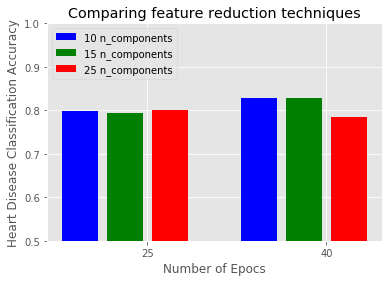

In [256]:
# from sklearn_evaluation import plot
components = [10,15,25]
# plot.grid_search(grid_search.cv_results_, change='param_clf__batch_size', kind='bar')
mean_scores = np.array(grid_search.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(batch_size), -1, len(epochs))


# select score for best epochs
mean_scores = mean_scores.max(axis=0)
print(mean_scores)
bar_offsets = (np.arange(len(epochs)) *
               (len(components) + 1) + .5)

import matplotlib.pyplot as plt

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(components, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=str(label) + ' n_components', color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Number of Epocs')
plt.xticks(bar_offsets + len(components) / 2, epochs)
plt.ylabel('Heart Disease Classification Accuracy')
plt.ylim((0.5, 1))
plt.legend(loc='upper left')

plt.savefig('GMM_reduction_Keras')

grid_search.best_params_